In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import tensorflow as tf

2024-10-02 21:12:00.762797: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 21:12:00.774866: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 21:12:00.793634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 21:12:00.810669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 21:12:00.815579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 21:12:00.839588: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Probably need to change this if your on MAC
spark = (
    SparkSession.builder.appName("Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '8g')
    .config('spark.executor.memory', '8g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/10/02 21:12:03 WARN Utils: Your hostname, Andy-PC resolves to a loopback address: 127.0.1.1; using 172.28.51.77 instead (on interface eth0)
24/10/02 21:12:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/02 21:12:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
full_transaction = spark.read.parquet("../data/curated/full_transactions")
full_transaction = full_transaction.drop("order_time")
full_transaction.show()

+--------------------+--------+--------------+------------+-------+-----------+-------------------+------------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|            order_id|postcode|order_datetime|merchant_abn|user_id|consumer_id|       dollar_value|     consumer_name|state|     gender|consumer_fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|  Tot_M|  Tot_P|  Tot_F|
+--------------------+--------+--------------+------------+-------+-----------+-------------------+------------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+

In [4]:
full_transaction.show()

+--------------------+--------+--------------+------------+-------+-----------+-------------------+------------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|            order_id|postcode|order_datetime|merchant_abn|user_id|consumer_id|       dollar_value|     consumer_name|state|     gender|consumer_fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|  Tot_M|  Tot_P|  Tot_F|
+--------------------+--------+--------------+------------+-------+-----------+-------------------+------------------+-----+-----------+--------------------------+--------------------+--------------------+--------------------+-----+

In [5]:
full_transaction.select("tags1").distinct().show(50,truncate = False)

+----------------------------------------------------------------+
|tags1                                                           |
+----------------------------------------------------------------+
|books, periodicals, newspapers                                  |
|shoe                                                            |
|gift, card, novelty, souvenir                                   |
|watch, clock, jewelry repair                                    |
|art dealers, galleries                                          |
|digital goods, books, movies, music                             |
|jewelry, watch, clock, silverware                               |
|lawn, garden supply outlets, including nurseries                |
|opticians, optical goods, eyeglasses                            |
|computers, computer peripheral equipment, software              |
|hobby, toy, game                                                |
|cable, satellite, other pay television, radio                

In [6]:
computer_transactions = full_transaction.filter(F.col("tags1") == "computer programming, data processing, integrated systems design").toPandas()
bicycle_transactions = full_transaction.filter(F.col("tags1") == "bicycle").toPandas()
artsupply_transactions = full_transaction.filter(F.col("tags1") == "artist supply, craft").toPandas()

In [7]:
pandas_transactions = pd.read_parquet("../data/curated/full_transactions")

In [8]:
def ranking_algorithm(df):
    merchant_aggregated = df.groupby("merchant_abn").agg({
        "dollar_value": "sum",
        "merchant_fraud_probability": "mean",  
        "consumer_fraud_probability": "mean",  
        "order_id": "count",  
        "consumer_id": pd.Series.nunique,
        "postcode": pd.Series.nunique, 
        "Median_tot_hhd_inc_weekly": "mean",  
        "Average_household_size": "mean", 
    })
    
    merchant_aggregated.columns = ["total_revenue", "merchant_fraud_probability", "consumer_fraud_probability", 
                            "order_count", "unique_consumers", "postcode_count", "household_income", "household_size"]

    merchant_aggregated["revenue_score"] = (merchant_aggregated["total_revenue"] - merchant_aggregated["total_revenue"].min())/(merchant_aggregated["total_revenue"].max() - merchant_aggregated["total_revenue"].min())

    merchant_aggregated["fraud_probability_score"] = 1 - (0.005 * merchant_aggregated["merchant_fraud_probability"] + 0.005 * merchant_aggregated["consumer_fraud_probability"])

    merchant_aggregated["market_potential_score"] = (merchant_aggregated["household_income"]/merchant_aggregated["household_size"]) / 2
    merchant_aggregated["market_potential_score"] = (merchant_aggregated["market_potential_score"] - merchant_aggregated["market_potential_score"].min())/(merchant_aggregated["market_potential_score"].max() - merchant_aggregated["market_potential_score"].min())

    order_score = (merchant_aggregated["order_count"] - merchant_aggregated["order_count"].min())/(merchant_aggregated["order_count"].max() - merchant_aggregated["order_count"].min())
    unique_consumers_score = (merchant_aggregated["unique_consumers"] - merchant_aggregated["unique_consumers"].min())/(merchant_aggregated["unique_consumers"].max() - merchant_aggregated["unique_consumers"].min())
    postcode_score = (merchant_aggregated["postcode_count"] - merchant_aggregated["postcode_count"].min())/(merchant_aggregated["postcode_count"].max() - merchant_aggregated["postcode_count"].min())

    merchant_aggregated["customer_quality_score"] = (order_score + unique_consumers_score + postcode_score) / 3
    merchant_aggregated["customer_quality_score"] = (merchant_aggregated["customer_quality_score"] - merchant_aggregated["customer_quality_score"].min())/(merchant_aggregated["customer_quality_score"].max() - merchant_aggregated["customer_quality_score"].min())

    merchant_aggregated["composite_score"] = (0.5 * merchant_aggregated["revenue_score"] + 
                                              0.2 * merchant_aggregated["fraud_probability_score"] + 
                                              0.2 * merchant_aggregated["market_potential_score"] + 
                                              0.1 * merchant_aggregated["customer_quality_score"])

    merchant_aggregated["rank"] = merchant_aggregated["composite_score"].rank(ascending=False)

    results = merchant_aggregated.sort_values(by="composite_score", ascending=False)

    return results

In [9]:
overall_ranks = ranking_algorithm(pandas_transactions)
overall_ranks.head(100)

,total_revenue,merchant_fraud_probability,consumer_fraud_probability,order_count,unique_consumers,postcode_count,household_income,household_size,revenue_score,fraud_probability_score,market_potential_score,customer_quality_score,composite_score,rank
merchant_abn,,,,,,,,,,,,,,
86578477987,7.971995e+06,26.375843,13.240226,227770,20111,2638,1606.615735,2.458293,0.965494,0.801920,0.264497,0.981061,0.794137,1.0
96680767841,8.222773e+06,26.937289,13.311787,26135,14641,2627,1609.668452,2.458190,0.995890,0.798755,0.265792,0.610690,0.771923,2.0
21439773999,7.876085e+06,26.751081,13.120062,100746,19975,2637,1606.675173,2.456467,0.953870,0.800644,0.265017,0.803353,0.770403,3.0
39649557865,8.256687e+06,27.415547,13.494647,18307,12085,2607,1607.587589,2.459180,1.000000,0.795449,0.264660,0.554989,0.767521,4.0
32361057556,7.880790e+06,26.251511,13.416940,71718,19531,2638,1604.007083,2.457245,0.954440,0.801658,0.263698,0.756053,0.765897,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29616684420,3.189579e+06,28.830799,12.327300,36967,16814,2637,1608.513891,2.458125,0.385851,0.794210,0.265330,0.662924,0.471126,96.0
76626119831,3.208747e+06,26.793200,13.359024,29935,15571,2632,1607.047403,2.458447,0.388174,0.799239,0.264634,0.631982,0.470060,97.0
22227727512,3.334483e+06,27.250139,13.315889,13271,9714,2571,1617.528596,2.465300,0.403414,0.797170,0.267118,0.504186,0.464983,98.0


In [10]:
computer_ranks = ranking_algorithm(computer_transactions)
bicycle_ranks = ranking_algorithm(bicycle_transactions)
artsupply_ranks = ranking_algorithm(artsupply_transactions)

In [11]:
computer_ranks.head(10)

,total_revenue,merchant_fraud_probability,consumer_fraud_probability,order_count,unique_consumers,postcode_count,household_income,household_size,revenue_score,fraud_probability_score,market_potential_score,customer_quality_score,composite_score,rank
merchant_abn,,,,,,,,,,,,,,
35909341340,8.027391e+06,27.430864,13.184810,31966,16006,2634,1605.628042,2.458321,1.000000,0.796922,0.648547,0.956392,0.884733,1.0
77590625261,6.325286e+06,29.152280,12.451624,20963,13031,2623,1603.812956,2.459595,0.787746,0.791980,0.641987,0.791469,0.759813,2.0
58454491168,5.594092e+06,26.923967,13.274065,22259,13536,2630,1602.499798,2.455735,0.696565,0.799010,0.644976,0.814728,0.718553,3.0
67400260923,4.726556e+06,26.965590,13.134125,31496,15923,2634,1600.656845,2.456775,0.588383,0.799501,0.638719,0.950293,0.676865,4.0
84703983173,3.544935e+06,26.369103,13.522692,35384,16579,2633,1607.027894,2.457673,0.441034,0.800541,0.653069,1.000000,0.611239,5.0
94455880010,2.250368e+06,26.658096,13.249579,22220,13488,2627,1606.693924,2.458560,0.279600,0.800462,0.650803,0.813014,0.511354,6.0
45244796758,1.535572e+06,26.754942,13.282305,7707,6391,2398,1609.313741,2.454639,0.190464,0.799814,0.663672,0.504444,0.438374,7.0
23661821077,1.202193e+06,25.729757,13.862009,11997,8996,2550,1605.963324,2.456756,0.148892,0.802041,0.651916,0.616553,0.426892,8.0
28687004922,1.199540e+06,28.401746,12.538733,11884,8912,2579,1604.241754,2.454384,0.148561,0.795298,0.651491,0.617477,0.425386,9.0


In [12]:
bicycle_ranks.head(10)

,total_revenue,merchant_fraud_probability,consumer_fraud_probability,order_count,unique_consumers,postcode_count,household_income,household_size,revenue_score,fraud_probability_score,market_potential_score,customer_quality_score,composite_score,rank
merchant_abn,,,,,,,,,,,,,,
87084550311,5.140465e+06,27.864658,14.094686,3996,3641,1975,1602.008759,2.459960,1.000000,0.790203,0.548555,0.443222,0.812074,1.0
52594457116,3.383386e+06,27.424176,13.308091,6541,5559,2327,1615.099220,2.461306,0.657668,0.796339,0.572736,0.598084,0.662458,2.0
79633007926,1.894725e+06,28.045174,12.728659,15451,10833,2603,1611.830108,2.460501,0.367633,0.796131,0.567308,0.974079,0.553912,3.0
76078244980,2.309002e+06,27.526277,14.052032,2265,2137,1456,1600.471523,2.450419,0.448347,0.792108,0.557854,0.295973,0.523763,4.0
54272781746,1.082268e+06,27.588161,12.883131,10925,8387,2532,1609.788192,2.463368,0.209342,0.797644,0.559553,0.798977,0.456008,5.0
22795471441,8.037596e+05,27.400233,12.944499,16318,11106,2603,1601.345631,2.455423,0.155080,0.798276,0.553102,1.000000,0.447816,6.0
70620117107,1.035076e+06,26.842933,13.148767,8331,6838,2439,1609.984036,2.458708,0.200148,0.800041,0.565976,0.687480,0.442025,7.0
62583219931,1.088022e+06,27.432793,12.911378,7308,6158,2390,1606.206212,2.455638,0.210463,0.798279,0.562470,0.639848,0.441366,8.0
55559667703,1.515309e+06,27.086117,14.235622,1457,1404,1061,1606.454358,2.465614,0.293711,0.793391,0.550064,0.206682,0.436215,9.0


In [13]:
artsupply_ranks.head(10)

,total_revenue,merchant_fraud_probability,consumer_fraud_probability,order_count,unique_consumers,postcode_count,household_income,household_size,revenue_score,fraud_probability_score,market_potential_score,customer_quality_score,composite_score,rank
merchant_abn,,,,,,,,,,,,,,
39649557865,8.256687e+06,27.415547,13.494647,18307,12085,2607,1607.587589,2.459180,1.000000,0.795449,0.380411,0.569881,0.792160,1.0
63123845164,7.204031e+06,26.426811,14.131258,9572,7605,2477,1610.455391,2.461419,0.872358,0.797210,0.382883,0.459889,0.718186,2.0
67978471888,6.747691e+06,27.418502,13.520486,10380,8103,2503,1598.905588,2.454817,0.817024,0.795305,0.370119,0.473223,0.688919,3.0
89932674734,6.503277e+06,27.323544,13.574194,14547,10377,2602,1599.781673,2.455895,0.787387,0.795511,0.370427,0.532659,0.680147,4.0
40515428545,6.513834e+06,27.050304,13.634583,10935,8402,2533,1610.248102,2.458043,0.788667,0.796576,0.386411,0.483209,0.679252,5.0
63290521567,3.682752e+06,26.263545,13.259400,152022,20098,2638,1606.952119,2.458486,0.445379,0.802385,0.380090,1.000000,0.559184,6.0
98072939449,2.980388e+06,26.184433,14.114542,4948,4372,2127,1614.954325,2.463682,0.360212,0.798505,0.388191,0.351688,0.452614,7.0
61080648284,1.985804e+06,26.350366,13.949791,3314,3054,1820,1591.820760,2.453229,0.239612,0.798499,0.359432,0.287279,0.380120,8.0
47480497674,1.186241e+04,27.136774,13.503614,11,11,11,1970.000000,2.472727,0.000258,0.796798,1.000000,0.000000,0.359489,9.0


Ignore everything below this point.

In [14]:
aggregated_transactions= full_transaction.groupBy('merchant_abn').agg((F.sum('dollar_value')).alias('dollar_value'),
                                                    F.sum(F.when(F.col("gender") == "Male", 1)).alias("Male_count"),
                                                    F.sum(F.when(F.col("gender") == "Female", 1)).alias("Female_count"),
                                                    F.sum(F.when(F.col("gender") == "Undisclosed", 1)).alias("Undisclosed_count"),
                                                    F.sum(F.when(F.col("state") == "VIC", 1)).alias("VIC_count"),
                                                    F.sum(F.when(F.col("state") == "WA", 1)).alias("WA_count"),
                                                    F.sum(F.when(F.col("state") == "NSW", 1)).alias("NSW_count"),
                                                    F.sum(F.when(F.col("state") == "SA", 1)).alias("SA_count"),
                                                    F.sum(F.when(F.col("state") == "QLD", 1)).alias("QLD_count"),
                                                    F.sum(F.when(F.col("state") == "TAS", 1)).alias("TAS_count"),
                                                    F.sum(F.when(F.col("state") == "NT", 1)).alias("NT_count"),
                                                    F.sum(F.when(F.col("state") == "ACT", 1)).alias("ACT_count"),
                                                    F.sum(F.when(F.col("tags2") == "a", 1)).alias("a_count"),
                                                    F.sum(F.when(F.col("tags2") == "b", 1)).alias("b_count"),
                                                    F.sum(F.when(F.col("tags2") == "c", 1)).alias("c_count"),
                                                    F.sum(F.when(F.col("tags2") == "d", 1)).alias("d_count"),
                                                    F.sum(F.when(F.col("tags2") == "e", 1)).alias("e_count"),
                                                    F.first("tags1").alias("tags1"),
                                                    F.first("tags3").alias("tags3")
                                                    )

aggregated_transactions = aggregated_transactions.fillna(0)
aggregated_transactions = aggregated_transactions.withColumn("revenue", F.col("dollar_value") * (F.col("tags3")))
aggregated_transactions.show()

+------------+------------------+----------+------------+-----------------+---------+--------+---------+--------+---------+---------+--------+---------+-------+-------+-------+-------+-------+--------------------+-----+--------------------+
|merchant_abn|      dollar_value|Male_count|Female_count|Undisclosed_count|VIC_count|WA_count|NSW_count|SA_count|QLD_count|TAS_count|NT_count|ACT_count|a_count|b_count|c_count|d_count|e_count|               tags1|tags3|             revenue|
+------------+------------------+----------+------------+-----------------+---------+--------+---------+--------+---------+---------+--------+---------+-------+-------+-------+-------+-------+--------------------+-----+--------------------+
| 10023283211| 583949.2453304273|      1204|        1228|              274|      695|     409|      633|     349|      456|      108|      30|       26|      0|      0|      0|      0|   2706|furniture, home f...| 0.18|  105110.86415947691|
| 10323485998|1109424.6019425131|   

In [15]:
full_transaction.select("tags1").distinct().show(100,truncate = False)

+----------------------------------------------------------------+
|tags1                                                           |
+----------------------------------------------------------------+
|books, periodicals, newspapers                                  |
|shoe                                                            |
|gift, card, novelty, souvenir                                   |
|watch, clock, jewelry repair                                    |
|art dealers, galleries                                          |
|digital goods, books, movies, music                             |
|jewelry, watch, clock, silverware                               |
|lawn, garden supply outlets, including nurseries                |
|opticians, optical goods, eyeglasses                            |
|computers, computer peripheral equipment, software              |
|hobby, toy, game                                                |
|cable, satellite, other pay television, radio                

In [16]:
aggregated_pandas = aggregated_transactions.toPandas()

columns= ['merchant_abn',
 'Male_count',
 'Female_count',
 'Undisclosed_count',
 'VIC_count',
 'WA_count',
 'NSW_count',
 'SA_count',
 'QLD_count',
 'TAS_count',
 'NT_count',
 'ACT_count',
 'a_count',
 'b_count',
 'c_count',
 'd_count',
 'e_count']

numeric_columns= ['merchant_abn',
 'Male_count',
 'Female_count',
 'Undisclosed_count',
 'VIC_count',
 'WA_count',
 'NSW_count',
 'SA_count',
 'QLD_count',
 'TAS_count',
 'NT_count',
 'ACT_count',
 'a_count',
 'b_count',
 'c_count',
 'd_count',
 'e_count']

aggregated_pandas[numeric_columns] = aggregated_pandas[numeric_columns].apply(pd.to_numeric, errors='coerce')

X = aggregated_pandas[columns].values
y = aggregated_pandas["revenue"].values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) 
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


/home/ache8119/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 27472951246848.0000   
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27272704688128.0000 
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26864204644352.0000 
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27198656348160.0000 
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25667949297664.0000 
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 28330164224000.0000
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 28013200670720.0000
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 26618990952448.0000
Epoch 9/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 27545384779776.0000
Epoch 10/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 24301885456384.0000
Epoch 11/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 25696179060736.0000
Epoch 12/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 30939210055680.0000
Epoch 13/1000
26/26 ━━━━━━━━━

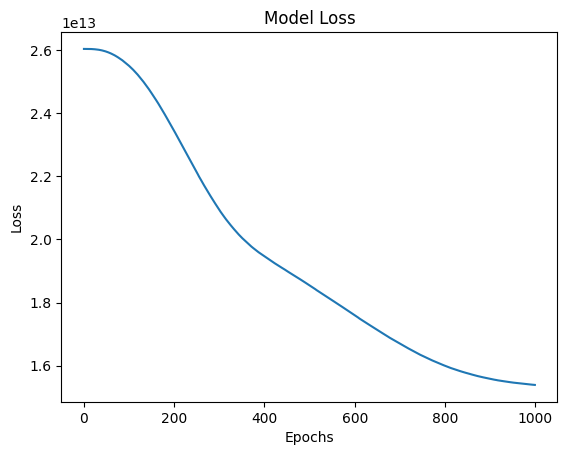

In [18]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=128)

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()


In [19]:
predictions = model.predict(X_test)

results = pd.DataFrame(X_test, columns=['merchant_abn',
 'Male_count',
 'Female_count',
 'Undisclosed_count',
 'VIC_count',
 'WA_count',
 'NSW_count',
 'SA_count',
 'QLD_count',
 'TAS_count',
 'NT_count',
 'ACT_count',
 'a_count',
 'b_count',
 'c_count',
 'd_count',
 'e_count'])

results['revenue'] = predictions

ranked_merchants = results.sort_values(by='revenue', ascending=False)
print(ranked_merchants)
predictions


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
     merchant_abn  Male_count  Female_count  Undisclosed_count  VIC_count  \
256      0.395765    0.787700      0.790905           0.795344   0.785308   
510      0.646831    0.622752      0.628218           0.626808   0.621434   
374      0.604446    0.391103      0.394097           0.394117   0.389228   
362      0.771333    0.343760      0.342489           0.341297   0.342269   
384      0.566130    0.314114      0.313513           0.316228   0.312196   
..            ...         ...           ...                ...        ...   
179      0.021697    0.000037      0.000084           0.000041   0.000096   
391      0.007958    0.000009      0.000037           0.000000   0.000000   
666      0.032282    0.000922      0.000978           0.001178   0.000917   
53       0.240166    0.010515      0.010687           0.010483   0.010614   
9        0.275649    0.040260      0.038825           0.039371   0.038902   

     WA_count  NSW_count  SA_count 

array([[ 3241744.2],
       [ 3708368.2],
       [ 1302182.5],
       [ 1575753.9],
       [ 1444700.6],
       [ 1396124. ],
       [ 1185455.6],
       [ 1636298.1],
       [ 1522827. ],
       [  824998.7],
       [ 1388633.9],
       [ 1521628.4],
       [ 1688764.4],
       [ 1234752.2],
       [ 1514922.5],
       [ 1255527.2],
       [ 1360802.5],
       [ 1352590. ],
       [ 1389255.4],
       [ 1421304.2],
       [ 2900964.8],
       [ 2040766.5],
       [ 3739479.8],
       [ 1830504.8],
       [ 2529308.8],
       [ 1510678.8],
       [ 1417162. ],
       [ 1621674.5],
       [ 8909826. ],
       [ 1637012.5],
       [ 1331091.8],
       [ 1494691.5],
       [ 1702712. ],
       [ 1333987. ],
       [ 1246214. ],
       [ 1393613.1],
       [ 1242445.1],
       [ 1478917.2],
       [ 1858814.2],
       [ 1268854.5],
       [ 1603831.2],
       [ 1427859.2],
       [ 1843849.8],
       [ 1220689.2],
       [ 1793457.2],
       [ 1313321.8],
       [ 1583516. ],
       [ 1529

In [22]:
predictions = np.squeeze(predictions) 

comparison_df = pd.DataFrame({
    'y_test': y_test,
    'predictions': predictions,
    'difference': y_test - predictions
})

mae = np.mean(np.abs(comparison_df['difference']))
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2026395.9274568316
